In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import math

# root dir
# data root dir
# train data root dir
# test data root dir
# val data root dir

In [2]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'val')

# Google Drive 마운트해서 데이터셋 가져옴

In [3]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


In [4]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'Chest_Xray_Pneumonia.zip'), '/content')

except Exception as err:
    print(str(err))

In [5]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
    
    shutil.rmtree(DATA_ROOT_DIR)
    
    print(DATA_ROOT_DIR + ' is removed !!!')

In [6]:
# 압축파일 풀기

# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

# Chest_Xray_Pneumonia/train 확인
# Chest_Xray_Pneumonia/test 확인
# Chest_Xray_Pneumonia/val 확인

In [7]:
import os

#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# test 정답 및 전체 데이터 개수 확인
#========================================================

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# validation 정답 및 전체 데이터 개수 확인
#========================================================

validation_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)

print(validation_label_name_list)

for label_name in validation_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['PNEUMONIA', 'NORMAL']
train label :  PNEUMONIA  =>  3875
train label :  NORMAL  =>  1341
['PNEUMONIA', 'NORMAL']
test label :  PNEUMONIA  =>  390
test label :  NORMAL  =>  234
['PNEUMONIA', 'NORMAL']
test label :  PNEUMONIA  =>  8
test label :  NORMAL  =>  8


# 이미지 shape 설정

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# ImageDataGenerator 이용하여 데이터 불러옴

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

test_datagen = ImageDataGenerator(rescale=1./255 )

In [18]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='training')

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='validation')


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


# 32개 데이터 가져와서 16 개의 데이터와 정답 출력

In [20]:
IMG_NUMS = 16

image_data, image_label = train_generator.next()

data = image_data[:IMG_NUMS]

label = image_label[:IMG_NUMS]

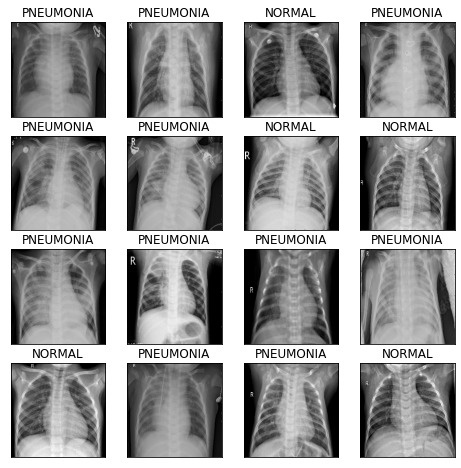

In [21]:
import matplotlib.pyplot as plt

class_dict = {0.0: 'NORMAL', 1.0: 'PNEUMONIA'}

plt.figure(figsize=(8,8))

for i in range(len(label)):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.show()

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [22]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [23]:
class_nums = train_generator.num_classes  # 정답개수

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                16400     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
No

In [24]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './Chest_Xray_Pneumonia_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,             # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           # auto는 알아서 best를 찾음. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                              verbose=1            # 로그를 출력
                             )



start_time = datetime.now()

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/20
131/131 [==============================] - 89s 568ms/step - loss: 0.4495 - acc: 0.7779 - val_loss: 0.2867 - val_acc: 0.8792
Epoch 2/20
131/131 [==============================] - 72s 551ms/step - loss: 0.2305 - acc: 0.9226 - val_loss: 0.1788 - val_acc: 0.9281
Epoch 3/20
131/131 [==============================] - 72s 546ms/step - loss: 0.1505 - acc: 0.9561 - val_loss: 0.1162 - val_acc: 0.9569
Epoch 4/20
131/131 [==============================] - 73s 560ms/step - loss: 0.1123 - acc: 0.9672 - val_loss: 0.0693 - val_acc: 0.9760
Epoch 5/20
131/131 [==============================] - 73s 559ms/step - loss: 0.0849 - acc: 0.9712 - val_loss: 0.0487 - val_acc: 0.9789
Epoch 6/20
131/131 [==============================] - 73s 555ms/step - loss: 0.0650 - acc: 0.9799 - val_loss: 0.0430 - val_acc: 0.9827
Epoch 7/20
131/131 [==============================] - 73s 558ms/step - loss: 0.0537 - acc: 0.9832 - val_loss: 0.0520 - val_acc: 0.9818
Epoch 8/20
131/131 [==============================] - 7

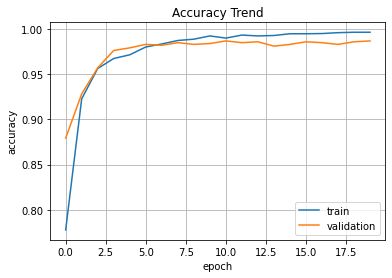

In [26]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

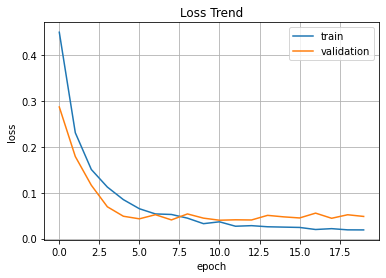

In [27]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [28]:
model.evaluate(test_generator)

20/20 [==============================] - 7s 347ms/step - loss: 1.2295 - acc: 0.8125


[1.2295359373092651, 0.8125]

In [29]:
test_simple_datagen = ImageDataGenerator(rescale=1./255 )

test_simple_generator = test_datagen.flow_from_directory(VALIDATION_DATA_ROOT_DIR, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 16 images belonging to 2 classes.


In [30]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 271ms/step - loss: 0.2205 - acc: 0.8750


[0.22053740918636322, 0.875]